# DAG-GNN for Grapes Dataset

In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
threshold=0.1

In [34]:
path_gt = 'src/grapes_data_clean__tauA0.0__thresh0.3/trueG'
path_pred = 'src/grapes_data_clean__tauA0.0__thresh0.3/predG'

# Load ground truth and predicted graphs
gt = np.genfromtxt(path_gt, delimiter=' ')
pred = np.genfromtxt(path_pred, delimiter=' ')
print(gt.shape, pred.shape)
data_order = ["Treatment","SproutN","BunchN","GrapeW","WoodW","SPAD06","NDVI06","SPAD08","NDVI08","Acid","Potass","Brix","pH","Anthoc","Polyph"]

(14, 14) (14, 14)


Text(0.5, 1.0, 'Confusion Matrix')

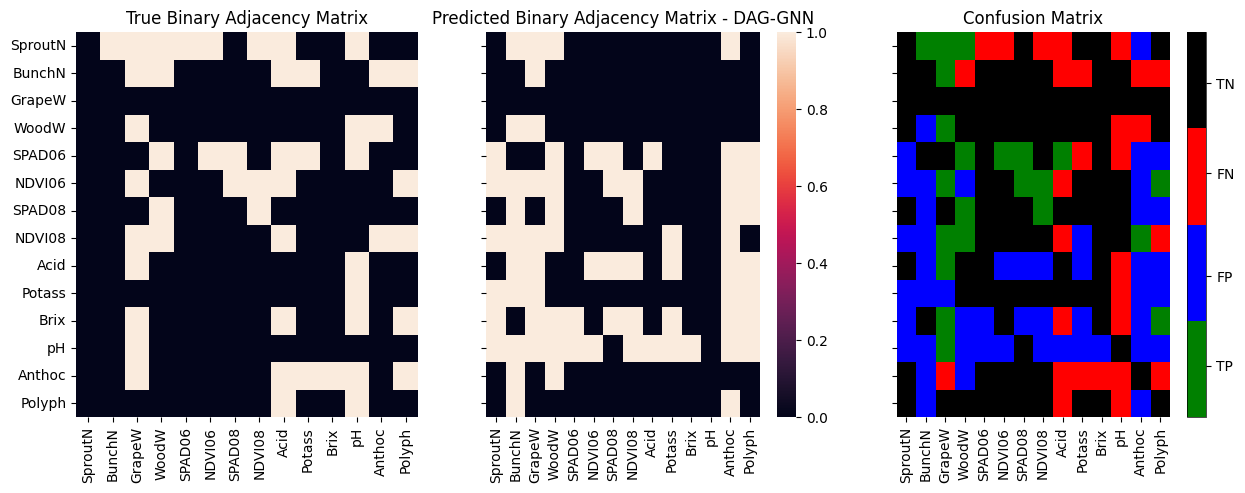

In [35]:
# Convert to a pandas dataframe with columns
df = pd.DataFrame(pred, columns=data_order[1:], index=data_order[1:])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
adj_matrix_df = pd.DataFrame(gt, columns=data_order[1:], index=data_order[1:])

sns.heatmap(adj_matrix_df,  fmt=".2f", cbar=False, ax=axs[0])
sns.heatmap(np.abs(df)>0.1, fmt=".2f",  cbar=True, ax=axs[1])
axs[1].set_yticklabels([])
# true positive matrix
# Define masks
tp = np.logical_and(adj_matrix_df, np.abs(df)>threshold).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), np.abs(df)>threshold).astype(int) * 2
fn = np.logical_and(adj_matrix_df, (np.abs(df)>threshold)==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), (np.abs(df)>threshold)==0).astype(int) * 4

# Combine masks into a single matrix
combined = tp + fp + fn + tn

# Create a colormap: green for TP, blue for FP, red for FN, black for TN
cmap = sns.color_palette(['green', 'blue', 'red', 'black'])

# Plot the combined matrix using the colormap
sns.heatmap(combined, cmap=cmap, cbar=True, ax=axs[2])
axs[2].set_yticklabels([])

# Customize the colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.outline.set_linewidth(0.5)
cbar.set_ticklabels(['TP', 'FP', 'FN', 'TN'])

axs[0].set_title("True Binary Adjacency Matrix")
axs[1].set_title("Predicted Binary Adjacency Matrix - DAG-GNN")
axs[2].set_title("Confusion Matrix")



In [7]:
import random
from scipy.spatial import distance

def generate_baseline_matrix( true_matrix, predicted_matrix):
    assert true_matrix.shape == predicted_matrix.shape
    num_edges_predicted = np.sum(true_matrix)
    print('this is num edges true',num_edges_predicted)
    # print(f"Number of edges true: {num_edges_true}")
    # print(f"Number of edges predicted: {num_edges_predicted}")

    # Copy the true matrix and flatten it
    baseline = true_matrix.copy().flatten()

    # Collect indices of zeros from the flattened matrix (non-edges)
    zero_indices = [i for i, x in enumerate(baseline) if x == 0]
    # print('this is zero indices',zero_indices)
    # Randomly select indices to turn into edges for the baseline
    random.shuffle(zero_indices)
    print('this is zero indices',len(zero_indices),zero_indices, )
    selected_indices = zero_indices[: int(num_edges_predicted)]
    print('this is selected indices',len(selected_indices), selected_indices)
    newbaseline = np.zeros((true_matrix.shape[1],true_matrix.shape[1])).copy().flatten()
    for i in selected_indices:
        newbaseline[i] = 1
    print('this is baseline',newbaseline.reshape(true_matrix.shape))
    return newbaseline.reshape(true_matrix.shape), np.sum(predicted_matrix)

def compute_metrics(true_matrix, predicted_matrix):
    # Compute TP, FP, and FN
    TP = np.sum(np.logical_and(true_matrix == 1, predicted_matrix == 1))
    FP = np.sum(np.logical_and(true_matrix == 0, predicted_matrix == 1))
    FN = np.sum(np.logical_and(true_matrix == 1, predicted_matrix == 0))
    # print(TP, FP, FN)
    # print(true_matrix)
    # Compute Precision, Recall, and F1-score
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    # print(recall)
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if precision + recall != 0
        else 0
    )

    return TP, precision, recall, f1


# Your provided function
def dist_between_matrices_normHamming(A, B):
    return distance.hamming(A.flatten(), B.flatten())

def calculate_hamming_distance(true_matrix, predicted_matrix):

    # print(predicted_matrix)
    baseline, num_edges_predicted = generate_baseline_matrix(
        true_matrix, predicted_matrix
    )

    baseham = dist_between_matrices_normHamming(predicted_matrix, baseline)
    normham = dist_between_matrices_normHamming(true_matrix, predicted_matrix)
    ratio = normham / baseham
    TP, precision, recall, f1 = np.round(
        compute_metrics(true_matrix, predicted_matrix), 2
    )

    return baseham, normham, ratio, num_edges_predicted


In [37]:
adj_matrix_adj = pd.DataFrame(gt, columns=data_order[1:], index=data_order[1:])
df = pd.DataFrame(pred, columns=data_order[1:], index=data_order[1:])
df = df.abs()>threshold



tp = np.logical_and(adj_matrix_df, df).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), df).astype(int) * 2
fn = np.logical_and(adj_matrix_df, df==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), df==0).astype(int) * 4

baseham, normham, ratio, num_edges_predicted = calculate_hamming_distance(adj_matrix_df.to_numpy(), df.to_numpy())

this is num edges true 51.0
this is zero indices 145 [184, 24, 154, 20, 68, 141, 159, 132, 6, 117, 125, 57, 121, 29, 55, 166, 86, 116, 167, 138, 105, 79, 89, 51, 36, 186, 50, 41, 192, 80, 32, 82, 172, 130, 143, 139, 136, 15, 163, 144, 102, 187, 9, 150, 25, 173, 28, 108, 113, 162, 69, 98, 160, 191, 174, 93, 47, 158, 85, 70, 157, 145, 183, 128, 56, 12, 37, 127, 71, 133, 134, 42, 95, 169, 103, 112, 147, 107, 124, 45, 115, 66, 126, 185, 58, 13, 63, 109, 21, 122, 18, 39, 43, 75, 88, 161, 30, 33, 96, 34, 52, 90, 129, 171, 73, 146, 195, 165, 118, 49, 38, 155, 84, 168, 120, 119, 46, 94, 188, 131, 180, 0, 149, 99, 164, 48, 74, 97, 152, 182, 14, 35, 10, 81, 175, 92, 104, 19, 140, 31, 194, 40, 135, 189, 60]
this is selected indices 51 [184, 24, 154, 20, 68, 141, 159, 132, 6, 117, 125, 57, 121, 29, 55, 166, 86, 116, 167, 138, 105, 79, 89, 51, 36, 186, 50, 41, 192, 80, 32, 82, 172, 130, 143, 139, 136, 15, 163, 144, 102, 187, 9, 150, 25, 173, 28, 108, 113, 162, 69]
this is baseline [[0. 0. 0. 0. 0. 

In [38]:

baseham, normham, ratio, num_edges_predicted = calculate_hamming_distance(adj_matrix_df.to_numpy(), df.to_numpy())
print(f"Baseham: {baseham}")
print(f"Normham: {normham}")
print(f"Ratio: {ratio}")
print(f"Total edges: {num_edges_predicted}")
print(f"True positives: {tp.sum().sum()}")
print(f"False positives: {fp.sum().sum()}")
print(f"False negatives: {fn.sum().sum()}")
print(f"True negatives: {tn.sum().sum()}")

precision = tp.sum().sum() / (tp.sum().sum() + fp.sum().sum()) if tp.sum().sum() + fp.sum().sum() != 0 else 0
recall = tp.sum().sum() / (tp.sum().sum() + fn.sum().sum()) if tp.sum().sum() + fn.sum().sum() != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
   

this is num edges true 51.0
this is zero indices 145 [51, 42, 164, 161, 145, 14, 109, 15, 73, 52, 81, 174, 30, 24, 143, 0, 192, 168, 152, 69, 119, 121, 60, 141, 118, 12, 95, 160, 31, 185, 113, 115, 163, 29, 131, 149, 70, 82, 144, 25, 6, 165, 19, 33, 175, 94, 71, 63, 134, 116, 171, 9, 154, 103, 184, 169, 96, 157, 50, 133, 180, 41, 84, 146, 68, 107, 89, 125, 104, 48, 129, 117, 88, 75, 80, 139, 112, 74, 108, 126, 187, 173, 183, 66, 166, 56, 32, 162, 138, 124, 40, 47, 43, 130, 90, 85, 18, 132, 92, 189, 93, 35, 155, 38, 195, 102, 120, 172, 122, 158, 34, 45, 21, 191, 37, 182, 13, 28, 36, 159, 46, 39, 186, 58, 98, 127, 57, 188, 20, 55, 147, 140, 97, 136, 79, 105, 49, 150, 99, 194, 128, 86, 167, 135, 10]
this is selected indices 51 [51, 42, 164, 161, 145, 14, 109, 15, 73, 52, 81, 174, 30, 24, 143, 0, 192, 168, 152, 69, 119, 121, 60, 141, 118, 12, 95, 160, 31, 185, 113, 115, 163, 29, 131, 149, 70, 82, 144, 25, 6, 165, 19, 33, 175, 94, 71, 63, 134, 116, 171]
this is baseline [[1. 0. 0. 0. 0. 0. 

Text(0.5, 1.0, 'Confusion Matrix')

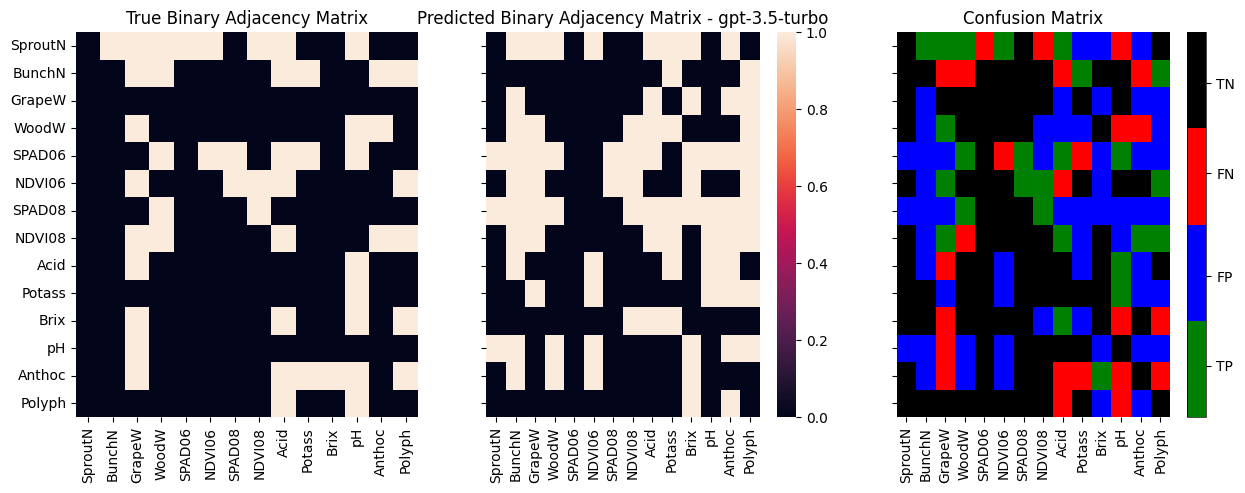

In [11]:
predicted_gpt35 = np.array(
    [[0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]]
)

# Convert to a pandas dataframe with columns
df = pd.DataFrame(predicted_gpt35, columns=data_order[1:], index=data_order[1:])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
adj_matrix_df = pd.DataFrame(gt, columns=data_order[1:], index=data_order[1:])

sns.heatmap(adj_matrix_df,  fmt=".2f", cbar=False, ax=axs[0])
sns.heatmap(np.abs(df)>0.1, fmt=".2f",  cbar=True, ax=axs[1])
axs[1].set_yticklabels([])
# true positive matrix
# Define masks
tp = np.logical_and(adj_matrix_df, np.abs(df)>0.3).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), np.abs(df)>0.3).astype(int) * 2
fn = np.logical_and(adj_matrix_df, (np.abs(df)>0.3)==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), (np.abs(df)>0.3)==0).astype(int) * 4

# Combine masks into a single matrix
combined = tp + fp + fn + tn

# Create a colormap: green for TP, blue for FP, red for FN, black for TN
cmap = sns.color_palette(['green', 'blue', 'red', 'black'])

# Plot the combined matrix using the colormap
sns.heatmap(combined, cmap=cmap, cbar=True, ax=axs[2])
axs[2].set_yticklabels([])

# Customize the colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.outline.set_linewidth(0.5)
cbar.set_ticklabels(['TP', 'FP', 'FN', 'TN'])

axs[0].set_title("True Binary Adjacency Matrix")
axs[1].set_title("Predicted Binary Adjacency Matrix - gpt-3.5-turbo")
axs[2].set_title("Confusion Matrix")


Text(0.5, 1.0, 'Confusion Matrix')

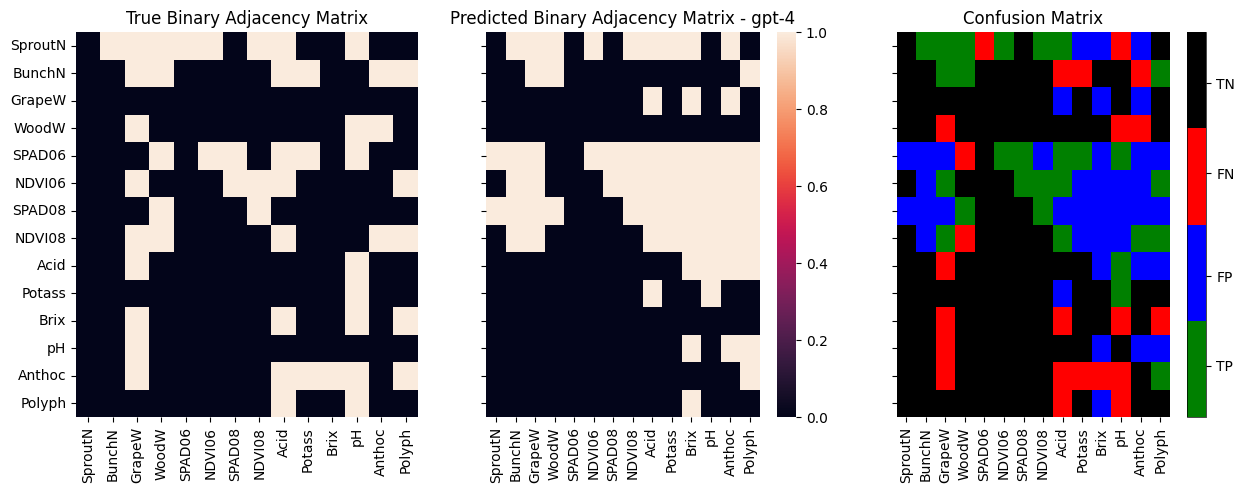

In [12]:
predicted_gpt4 = np.array(
[[0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]
)

# Convert to a pandas dataframe with columns
df = pd.DataFrame(predicted_gpt4, columns=data_order[1:], index=data_order[1:])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
adj_matrix_df = pd.DataFrame(gt, columns=data_order[1:], index=data_order[1:])

sns.heatmap(adj_matrix_df,  fmt=".2f", cbar=False, ax=axs[0])
sns.heatmap(np.abs(df)>0.1, fmt=".2f",  cbar=True, ax=axs[1])
axs[1].set_yticklabels([])
# true positive matrix
# Define masks
tp = np.logical_and(adj_matrix_df, np.abs(df)>0.3).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), np.abs(df)>0.3).astype(int) * 2
fn = np.logical_and(adj_matrix_df, (np.abs(df)>0.3)==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), (np.abs(df)>0.3)==0).astype(int) * 4

# Combine masks into a single matrix
combined = tp + fp + fn + tn

# Create a colormap: green for TP, blue for FP, red for FN, black for TN
cmap = sns.color_palette(['green', 'blue', 'red', 'black'])

# Plot the combined matrix using the colormap
sns.heatmap(combined, cmap=cmap, cbar=True, ax=axs[2])
axs[2].set_yticklabels([])

# Customize the colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.outline.set_linewidth(0.5)
cbar.set_ticklabels(['TP', 'FP', 'FN', 'TN'])

axs[0].set_title("True Binary Adjacency Matrix")
axs[1].set_title("Predicted Binary Adjacency Matrix - gpt-4")
axs[2].set_title("Confusion Matrix")


# DAG-GNN for the Arctic Sea Ice Dataset

In [28]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
threshold=0.1

In [29]:
path_gt = 'src/arctic/arctic_data_clean__tauA0.0__thresh0.3/trueG'
path_pred = 'src/arctic/arctic_data_clean__tauA0.0__thresh0.3/predG'

# Load ground truth and predicted graphs
gt = np.genfromtxt(path_gt, delimiter=' ')
pred = np.genfromtxt(path_pred, delimiter=' ')
print(gt.shape, pred.shape)
data_order = ["HFLX","SW","LW","SLP","Precip","RH","u10m","v10m","sea_ice","CC","CW","GH"]

(12, 12) (12, 12)


Text(0.5, 1.0, 'Confusion Matrix')

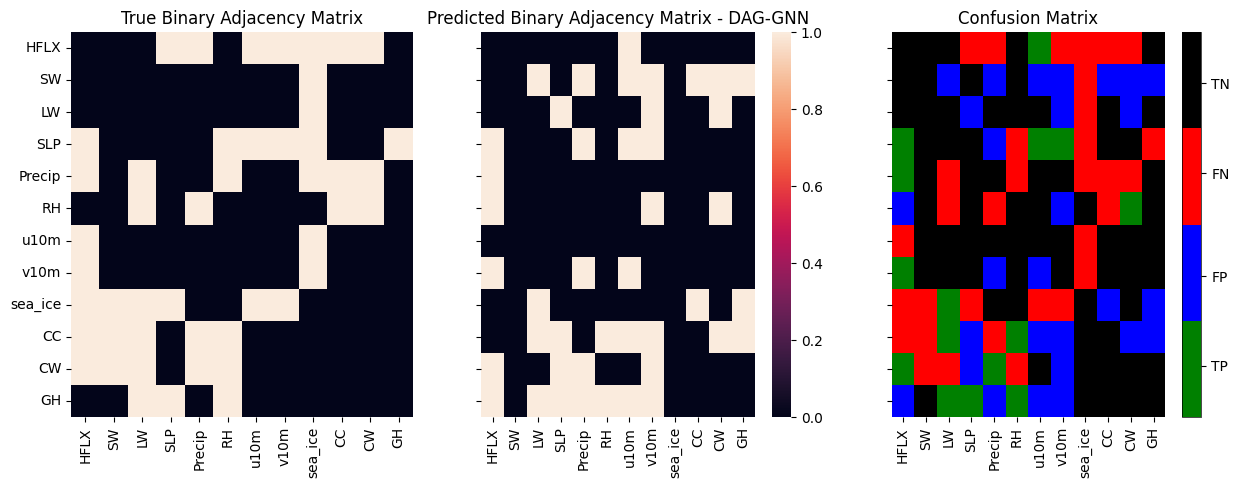

In [30]:
# Convert to a pandas dataframe with columns
df = pd.DataFrame(pred, columns=data_order, index=data_order)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
adj_matrix_df = pd.DataFrame(gt, columns=data_order, index=data_order)

sns.heatmap(adj_matrix_df,  fmt=".2f", cbar=False, ax=axs[0])
sns.heatmap(np.abs(df)>0.1, fmt=".2f",  cbar=True, ax=axs[1])
axs[1].set_yticklabels([])
# true positive matrix
# Define masks
tp = np.logical_and(adj_matrix_df, np.abs(df)>threshold).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), np.abs(df)>threshold).astype(int) * 2
fn = np.logical_and(adj_matrix_df, (np.abs(df)>threshold)==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), (np.abs(df)>threshold)==0).astype(int) * 4

# Combine masks into a single matrix
combined = tp + fp + fn + tn

# Create a colormap: green for TP, blue for FP, red for FN, black for TN
cmap = sns.color_palette(['green', 'blue', 'red', 'black'])

# Plot the combined matrix using the colormap
sns.heatmap(combined, cmap=cmap, cbar=True, ax=axs[2])
axs[2].set_yticklabels([])

# Customize the colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.outline.set_linewidth(0.5)
cbar.set_ticklabels(['TP', 'FP', 'FN', 'TN'])

axs[0].set_title("True Binary Adjacency Matrix")
axs[1].set_title("Predicted Binary Adjacency Matrix - DAG-GNN")
axs[2].set_title("Confusion Matrix")

In [31]:
adj_matrix_adj = pd.DataFrame(gt, columns=data_order, index=data_order)
df = pd.DataFrame(pred, columns=data_order, index=data_order)
df = df.abs()>threshold
tp = np.logical_and(adj_matrix_df, df).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), df).astype(int) * 2
fn = np.logical_and(adj_matrix_df, df==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), df==0).astype(int) * 4


In [32]:

baseham, normham, ratio, num_edges_predicted = calculate_hamming_distance(adj_matrix_df.to_numpy(), df.to_numpy())
print(f"Baseham: {baseham}")
print(f"Normham: {normham}")
print(f"Ratio: {ratio}")
print(f"Total edges: {num_edges_predicted}")
print(f"True positives: {tp.sum().sum()}")
print(f"False positives: {fp.sum().sum()}")
print(f"False negatives: {fn.sum().sum()}")
print(f"True negatives: {tn.sum().sum()}")

precision = tp.sum().sum() / (tp.sum().sum() + fp.sum().sum()) if tp.sum().sum() + fp.sum().sum() != 0 else 0
recall = tp.sum().sum() / (tp.sum().sum() + fn.sum().sum()) if tp.sum().sum() + fn.sum().sum() != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

this is num edges true 48.0
this is zero indices 96 [28, 132, 111, 5, 95, 37, 52, 106, 81, 2, 0, 75, 88, 138, 21, 133, 60, 118, 66, 29, 11, 54, 82, 31, 30, 123, 18, 26, 15, 19, 24, 94, 13, 67, 25, 114, 46, 91, 68, 51, 33, 105, 23, 141, 40, 89, 115, 93, 22, 45, 116, 128, 142, 85, 63, 117, 101, 27, 35, 34, 77, 126, 107, 87, 131, 17, 1, 12, 140, 65, 90, 100, 104, 59, 49, 86, 38, 73, 139, 39, 79, 71, 119, 55, 74, 129, 14, 130, 83, 16, 76, 61, 143, 78, 136, 127]
this is selected indices 48 [28, 132, 111, 5, 95, 37, 52, 106, 81, 2, 0, 75, 88, 138, 21, 133, 60, 118, 66, 29, 11, 54, 82, 31, 30, 123, 18, 26, 15, 19, 24, 94, 13, 67, 25, 114, 46, 91, 68, 51, 33, 105, 23, 141, 40, 89, 115, 93]
this is baseline [[1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1.

# DAG-GNN for Alzheimer's Disease Dataset

In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
threshold=0.1

In [23]:
path_gt = 'src/alzheimers/alzheimers_data_clean__tauA0.0__thresh0.3/trueG'
path_pred = 'src/alzheimers/alzheimers_data_clean__tauA0.0__thresh0.3/predG'

# Load ground truth and predicted graphs
gt = np.genfromtxt(path_gt, delimiter=' ')
pred = np.genfromtxt(path_pred, delimiter=' ')
print(gt.shape, pred.shape)
data_order = ['APOE4', 'Sex', 'Age', 'Education', 'AV45', 'Tau Levels', 'Brain Volume', 'Ventricular Volume','MOCA Score']

(9, 9) (9, 9)


Text(0.5, 1.0, 'Confusion Matrix')

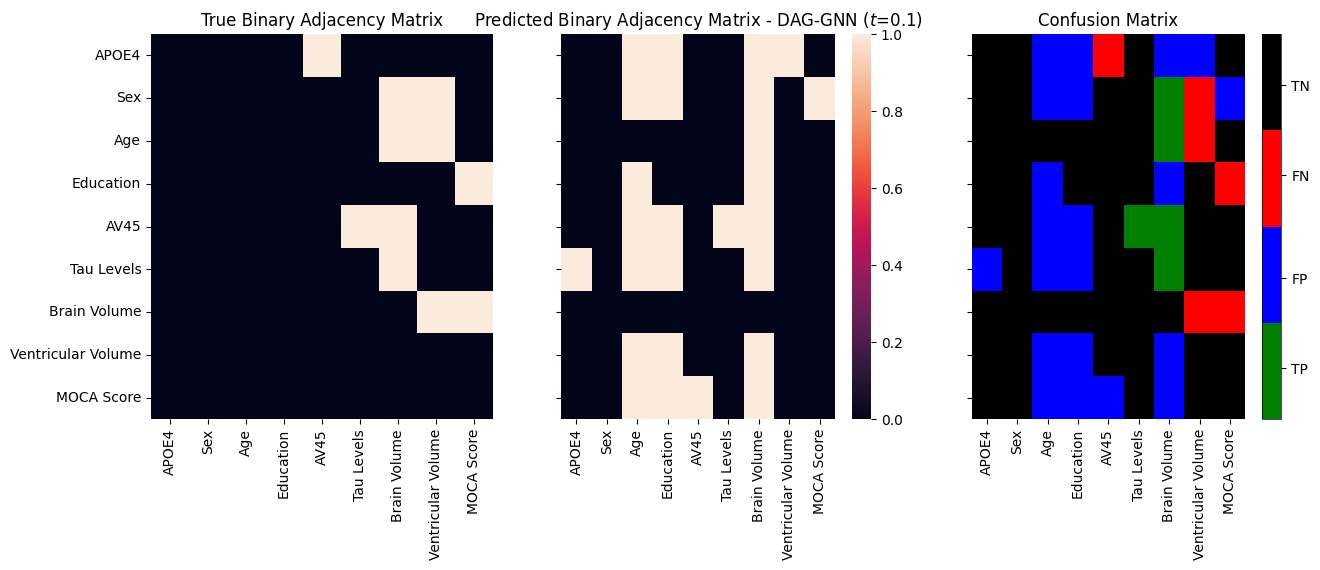

In [24]:
# Convert to a pandas dataframe with columns
df = pd.DataFrame(pred, columns=data_order, index=data_order)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
adj_matrix_df = pd.DataFrame(gt, columns=data_order, index=data_order)

sns.heatmap(adj_matrix_df,  fmt=".2f", cbar=False, ax=axs[0])
sns.heatmap(np.abs(df)>0.1, fmt=".2f",  cbar=True, ax=axs[1])
axs[1].set_yticklabels([])
# true positive matrix
# Define masks
tp = np.logical_and(adj_matrix_df, np.abs(df)>threshold).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), np.abs(df)>threshold).astype(int) * 2
fn = np.logical_and(adj_matrix_df, (np.abs(df)>threshold)==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), (np.abs(df)>threshold)==0).astype(int) * 4

# Combine masks into a single matrix
combined = tp + fp + fn + tn

# Create a colormap: green for TP, blue for FP, red for FN, black for TN
cmap = sns.color_palette(['green', 'blue', 'red', 'black'])

# Plot the combined matrix using the colormap
sns.heatmap(combined, cmap=cmap, cbar=True, ax=axs[2])
axs[2].set_yticklabels([])

# Customize the colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_ticks([1.4, 2.1, 2.9, 3.6])
cbar.outline.set_linewidth(0.5)
cbar.set_ticklabels(['TP', 'FP', 'FN', 'TN'])

axs[0].set_title("True Binary Adjacency Matrix")
axs[1].set_title(f"Predicted Binary Adjacency Matrix - DAG-GNN ($t$={threshold})")
axs[2].set_title("Confusion Matrix")

In [25]:
adj_matrix_adj = pd.DataFrame(gt, columns=data_order, index=data_order)
df = pd.DataFrame(pred, columns=data_order, index=data_order)
df = df.abs()>threshold
tp = np.logical_and(adj_matrix_df, df).astype(int)
fp = np.logical_and(~adj_matrix_df.astype(bool), df).astype(int) * 2
fn = np.logical_and(adj_matrix_df, df==0).astype(int) * 3
tn = np.logical_and(~adj_matrix_df.astype(bool), df==0).astype(int) * 4

In [26]:

baseham, normham, ratio, num_edges_predicted = calculate_hamming_distance(adj_matrix_df.to_numpy(), df.to_numpy())
print(f"Baseham: {baseham}")
print(f"Normham: {normham}")
print(f"Ratio: {ratio}")
print(f"Total edges: {num_edges_predicted}")
print(f"True positives: {tp.sum().sum()}")
print(f"False positives: {fp.sum().sum()}")
print(f"False negatives: {fn.sum().sum()}")
print(f"True negatives: {tn.sum().sum()}")

precision = tp.sum().sum() / (tp.sum().sum() + fp.sum().sum()) if tp.sum().sum() + fp.sum().sum() != 0 else 0
recall = tp.sum().sum() / (tp.sum().sum() + fn.sum().sum()) if tp.sum().sum() + fn.sum().sum() != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

this is num edges true 11.0
this is zero indices 70 [22, 26, 79, 73, 17, 78, 5, 64, 3, 20, 6, 72, 74, 50, 10, 28, 80, 56, 59, 31, 63, 45, 32, 47, 0, 76, 34, 55, 44, 8, 38, 57, 77, 43, 52, 58, 46, 27, 33, 19, 60, 49, 14, 18, 48, 66, 37, 54, 30, 40, 29, 1, 70, 21, 75, 53, 71, 2, 68, 7, 12, 65, 36, 39, 11, 13, 69, 9, 67, 23]
this is selected indices 11 [22, 26, 79, 73, 17, 78, 5, 64, 3, 20, 6]
this is baseline [[0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0.]]
Baseham: 0.35802469135802467
Normham: 0.3333333333333333
Ratio: 0.9310344827586207
Total edges: 26
True positives: 5
False positives: 42
False negatives: 18
True negatives: 196
Precision: 0.10638297872340426
Recall: 0.21739130434782608
F1-score: 0.14285714285714285
